In [1]:
%pylab inline
import pandas as pd
import seaborn as sns

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

Populating the interactive namespace from numpy and matplotlib


# Recommender systems

Typical machine learning datasets are of the form:

$$
\begin{array}{cc}
  input&target\\
  \mathbf{x}_1&y_1\\
  \mathbf{x}_2&y_2\\  
  \vdots & \vdots \\
  \mathbf{x}_N&y_N
\end{array}
$$

a set of input vectors ($\mathbf{x}_i$) and their associated targets ($y_i$), that we would like to predict.

Here it is easy to use standard algorithms like linear regression.

In recommendation probles, the dataset can be better viewed as:
$$
\begin{array}{ccc}
  user&item&rating\\
  u_1&v_1&r(u_1, v_1)\\
  \vdots & \vdots \\
  u_N&v_N&r(u_N, v_N)
\end{array}
$$

which is a set of triplets of users, items and ratings which tell us what rating users gave to certain items. These items can be different for all users, so we never had the "full" picture.

You can visualize this as a matrix completion problem:

<img src="images/rating_matrix1.png" height="500" width="500">

Alot of ratings are actually missing from this matrix. They are not zero, they are simply missing.

## Load the MovieLens small dataset

http://grouplens.org/datasets/movielens/
> GroupLens Research has collected and made available rating data sets from the MovieLens web site (http://movielens.org). The data sets were collected over various periods of time, depending on the size of the set. 
> 
> Small: 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users. Last updated 10/2016.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ratings = pd.read_csv('../data/ratings.csv')
movies = pd.read_csv('../data/movies.csv')
movie_titles = movies.title.tolist()

In [37]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [38]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [39]:
# How many users?
print(ratings.userId.nunique(), 'users')

# How many movies?
print(ratings.movieId.nunique(), 'movies')

# How possible ratings?
print(ratings.userId.nunique() * ratings.movieId.nunique(), 'possible ratings')

# How many entries are present?
print(len(ratings), 'ratings')
print(100 * (float(len(ratings)) / (ratings.userId.nunique() * ratings.movieId.nunique())), '% of possible ratings')

668 users
10325 movies
6897100 possible ratings
105339 ratings
1.5272940801206305 % of possible ratings


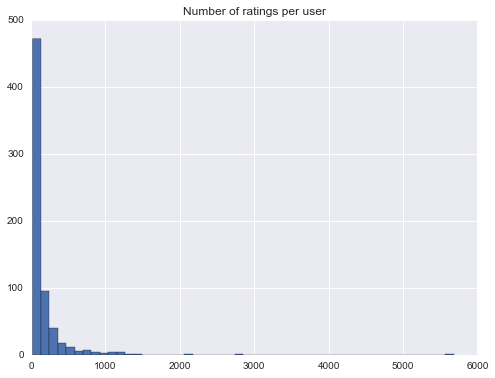

In [28]:
# Number of ratings per users
plt.hist(ratings.groupby('userId').apply(lambda x: len(x)).values, bins=50)
plt.title("Number of ratings per user")
plt.show()

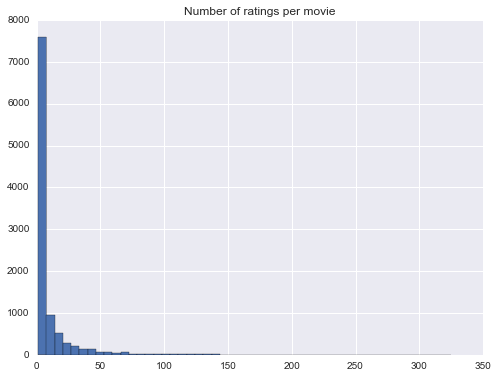

In [30]:
# Number of ratings per movie
plt.hist(ratings.groupby('movieId').apply(lambda x: len(x)).values, bins=50)
plt.title('Number of ratings per movie')
plt.show()

# Recommending new movies to users

In [17]:
df = movies.join(ratings, on=['movieId'], rsuffix='_r').join(tags, on=['movieId'], rsuffix='_t')
del df['movieId_r']
del df['userId_t']
del df['movieId_t']
del df['timestamp_t']

In [40]:
rp = df.pivot_table(columns=['movieId'],index=['userId'],values='rating')
rp = rp.fillna(0); # Replace NaN
rp.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,104913,104925,104944,104947,104956,105197,105211,105213,105223,105266
userId,,,,,,,,,,,,,,,,,,,,,
1.0,1.5,4.0,4.0,4.0,4.0,3.0,4.0,3.0,0.5,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We would like to produce estimates $\tilde{r}$ for all the missing ratings (encoded with $0$)

<img src="images/rating_matrix2.png" height="500" width="500">

## Some ideas:

### Mean filling: prediction is the average rating a given item.
 - Simple and efficient
 - Impersonal; everyone gets same predictions
 - Imprecise for movies with few ratings

### Content filtering: perform feature engineering on each item and build a model for each user using these features
 - Requires careful feature engineering of items
 - As many classifiers as users (could be thousands)
 - Information is not shared across users

### Matrix factorization: discover hidden attributes of the items and each user's preference for these attributes
 - AKA latent embedding
 - Latent variables are sometimes called "factors", "concepts", or "topics"
 - Imagine that each item has a set of hidden attributes, and users have preferences for each of these attributes. The estimated rating could be the linear combination of the attributes and preferences (dot product).
 
 
Completing the user-item rating matrix by sharing information across rows (users) and columns (items) is referred to as **collaborative filtering**

<img src="images/rating_matrix3.png" height="500" width="500">

This is like decomposing the matrix...

<img src="images/factorization.svg" height="700" width="700">

### Matrix factorization via alternating least squares (ALS)

We have users $u$ for items $i$ in a matrix

$$ Q_{ui} = \cases{
r  &amp; \text{if user u rate item i} \cr
0 &amp; \text{if user u did not rate item i}
} $$
where $r$ is what rating values can be. 

We want to *learn* the **factor matrices** for movies $Y \in \mathbb{R}^{f \times n}$ (each movie is a column vector) and for users $X \in \mathbb{R}^{m \times f}$ (each user is a row vector) such that
$$
Q \approx Y X
$$

We have two unknown variables. Therefore, we will adopt an **alternating least squares** approach:
 - Randomly initialize $X$ and $Y$
 - Estimate $Y$ using $X$
 - Estimate $X$ by using $Y$
 - Iterate until convergence
 
**Problem**: $X$ and $Y$ are missing entries!
 - May want to penalize the movies that do not have ratings in the update rule.
 - Removes making assumptions around the movies that are not rated
To do this, introduce **weight matrix** $W$ where:
$$
w_{ui} = \cases{
0 &\text{if  } q_{ui} \leq 0.5 \cr
1 &\text{ else} 
}
$$

Then, cost functions that we are trying to minimize is in the following:
$$ J(x_u) = (q_u - x_u Y) W_u (q_u - x_u Y)^T + \lambda x_u x_u^T $$
$$ J(y_i) = (q_i - X y_i) W_i (q_i - X y_i)^T + \lambda y_i y_i^T $$

$\lambda$ is a regularization term to avoid overfitting; it penalizes very large values of $x$ and $y$.

Gradient descent could be used, but regularized least squares has a closed-form solution which is more efficient to use:
$$ x_u = (Y W_u Y^T + \lambda I)^{-1} Y W_u q_u $$
$$ y_i = (X^T Wi X + \lambda I)^{-1} X^T W_i q_i $$
where $W_u \in \mathbb{R}^{nxn}$ and $W_u \in \mathbb{R}^{mxm}$ diagonal matrices.

## Implementation

In [41]:
Q = rp.values
Q

array([[ 1.5,  4. ,  4. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       ..., 
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  1.5,  2.5,  3. ]])

In [42]:
Q.shape

(456, 9796)

In [44]:
W = Q<=0.5
W[W == True] = 0
W[W == False] = 1
# To be consistent with our Q matrix
W = W.astype(np.float64, copy=False)

In [45]:
W

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

### Parameters

In [51]:
lambda_ = 0.1
n_factors = 100
m, n = Q.shape
n_iterations = 5

In [52]:
X = 5 * np.random.rand(m, n_factors) 
Y = 5 * np.random.rand(n_factors, n)

In [53]:
def get_error(Q, X, Y, W):
    return np.sum((W * (Q - np.dot(X, Y)))**2)

In [54]:
errors = []
for ii in range(n_iterations):
    X = np.linalg.solve(np.dot(Y, Y.T) + lambda_ * np.eye(n_factors), 
                        np.dot(Y, Q.T)).T
    Y = np.linalg.solve(np.dot(X.T, X) + lambda_ * np.eye(n_factors),
                        np.dot(X.T, Q))
    print('{}th iteration is completed'.format(ii))
    errors.append(get_error(Q, X, Y, W))
Q_hat = np.dot(X, Y)
print('Error of rated movies: {}'.format(get_error(Q, X, Y, W)))

0th iteration is completed
1th iteration is completed
2th iteration is completed
3th iteration is completed
4th iteration is completed
Error of rated movies: 29152.060365247627


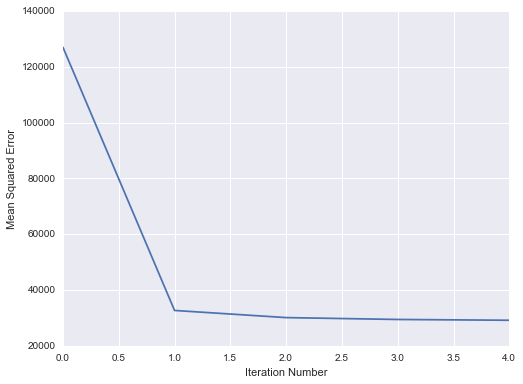

In [55]:
plt.plot(errors);
plt.xlabel('Iteration Number');
plt.ylabel('Mean Squared Error');

In [56]:
def print_recommendations(limit=100, W=W, Q=Q, Q_hat=Q_hat, movie_titles=movie_titles):
    #Q_hat -= np.min(Q_hat)
    #Q_hat[Q_hat < 1] *= 5
    Q_hat -= np.min(Q_hat)
    Q_hat *= float(5) / np.max(Q_hat)
    movie_ids = np.argmax(Q_hat - 5 * W, axis=1)
    for jj, movie_id in list(zip(range(m), movie_ids))[:limit]:
        #if Q_hat[jj, movie_id] < 0.1: continue
        print('User {} liked {}\n'.format(jj + 1, ', '.join([movie_titles[ii] for ii, qq in enumerate(Q[jj]) if qq > 3])))
        print('User {} did not like {}\n'.format(jj + 1, ', '.join([movie_titles[ii] for ii, qq in enumerate(Q[jj]) if qq < 3 and qq != 0])))
        print('\n User {} recommended movie is {} - with predicted rating: {}'.format(
                    jj + 1, movie_titles[movie_id], Q_hat[jj, movie_id]))
        print('\n' + 100 *  '-' + '\n')
print_recommendations()

User 1 liked Jumanji (1995), Grumpier Old Men (1995), Waiting to Exhale (1995), Father of the Bride Part II (1995), Sabrina (1995), GoldenEye (1995), Dracula: Dead and Loving It (1995), Cutthroat Island (1995), Casino (1995), Sense and Sensibility (1995), Get Shorty (1995), Copycat (1995), Assassins (1995), Powder (1995), Leaving Las Vegas (1995), Now and Then (1995), City of Lost Children, The (Cité des enfants perdus, La) (1995), Shanghai Triad (Yao a yao yao dao waipo qiao) (1995), Twelve Monkeys (a.k.a. 12 Monkeys) (1995), Babe (1995), Carrington (1995), Dead Man Walking (1995), Clueless (1995), Cry, the Beloved Country (1995), Richard III (1995), Dead Presidents (1995), Restoration (1995), Mortal Kombat (1995), To Die For (1995), How to Make an American Quilt (1995), Seven (a.k.a. Se7en) (1995), Pocahontas (1995), When Night Is Falling (1995), Usual Suspects, The (1995), Mighty Aphrodite (1995), Big Green, The (1995), Georgia (1995), Indian in the Cupboard, The (1995), Eye for an 